**UNet**, evolved from the traditional convolutional neural network, was first designed and applied in 2015 to process biomedical images. As a general convolutional neural network focuses its task on image classification, where input is an image and output is one label, but in biomedical cases, it requires us not only to distinguish whether there is a disease, but also to localise the area of abnormality.\
UNet is dedicated to solving this problem. **The reason it is able to localise and distinguish borders is by doing classification on every pixel, so the input and output share the same size.**

In [45]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
from cv2 import imshow

from keras import optimizers
from keras import backend as K
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Reshape, Dropout
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

### Get the data
Let's first import all the images and associated masks. I downsample both the training, test, and validating images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

Images are usually represented as Height x Width x #Channels where **Channels** is **3 for RGB images** and **1 for grayscale images**. Sometimes you see Width x Height x #Channels, but the third dimension is the “channels.”

After storing the image and mask we have picked only 544 images with their corresponding masks.

In [46]:
# Set size parameters
width = 256
height = 256
channels = 1
seg_channels = 4

train_path = 'keras_png_slices_data/keras_png_slices_train'# path of training data
test_path = 'keras_png_slices_data/keras_png_slices_test'# path of testing data
validate_path = 'keras_png_slices_data/keras_png_slices_validate'# path of validating data

seg_train_path = 'keras_png_slices_data/keras_png_slices_seg_train'# same for seg img
seg_test_path = 'keras_png_slices_data/keras_png_slices_seg_test'
seg_validate_path = 'keras_png_slices_data/keras_png_slices_seg_validate'

# Get train and IDs
# Python method walk() generates the file names in a directory tree by walking the tree
img_train_ids = next(os.walk(train_path))[2]
img_train_ids.sort()
img_train_ids = img_train_ids[:544] # here we use 544 as test file is 544
img_test_ids = next(os.walk(test_path))[2]
img_test_ids.sort()
img_test_ids = img_test_ids[:544]
img_validate_ids = next(os.walk(validate_path))[2]
img_validate_ids.sort()
img_validate_ids = img_validate_ids[:544]

seg_train_ids = next(os.walk(seg_train_path))[2]
seg_train_ids.sort()
seg_train_ids = seg_train_ids[:544]
seg_test_ids = next(os.walk(seg_test_path))[2]
seg_test_ids.sort()
seg_test_ids = seg_test_ids[:544]
seg_validate_ids = next(os.walk(seg_validate_path))[2]
seg_validate_ids.sort()
seg_validate_ids = seg_validate_ids[:544]

In [47]:
# Get and resize train images and masks
img_train = np.zeros((544, height, width, channels), dtype=np.float32)
img_test = np.zeros((544, height, width, channels), dtype=np.float32)
img_validate = np.zeros((544, height, width, channels), dtype=np.float32)

seg_train = np.zeros((544, height, width, seg_channels), dtype=np.float32)
seg_test = np.zeros((544, height, width, seg_channels), dtype=np.float32)
seg_validate = np.zeros((544, height, width, seg_channels), dtype=np.float32)

input image is normalized with zero mean and unit variance by:\
image = (image - image.mean())/image.std()

In [51]:
def load_img(i):
    # Load a grayscale img as grayscale and uint between 0 and 255
    img = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape + (1,))
    img = (img - img.mean())/img.std()
    return img

def load_mask(i):
    mask = cv2.imread(i,cv2.IMREAD_GRAYSCALE)
    classes = np.unique(mask)
    res = np.zeros(mask.shape + (len(classes),))
    for n in range(len(classes)):
        c = classes[n]
        res[:,:,n][mask == c] = 1
    return res

In [52]:
print('Getting and resizing images ... ')

for i in range(len(img_train_ids)):
    img_train[i] = load_img(train_path + "/" + img_train_ids[i])
for i in range(len(img_test_ids)):
    img_test[i] = load_img(test_path + "/" + img_test_ids[i])
for i in range(len(img_validate_ids)):
    img_validate[i] = load_img(validate_path + "/" + img_validate_ids[i])

for i in range(len(seg_train_ids)):
    seg_train[i] = load_mask(seg_train_path + "/" + seg_train_ids[i])
for i in range(len(seg_test_ids)):
    seg_test[i] = load_mask(seg_test_path + "/" + seg_test_ids[i])
for i in range(len(seg_validate_ids)):
    seg_validate[i] = load_mask(seg_validate_path + "/" + seg_validate_ids[i])
    
print("finish!")
print("the shape of image: ", img_train.shape)
print("the shape of mask: ", seg_train.shape)

Getting and resizing images ... 
finish!
the shape of image:  (544, 256, 256, 1)
the shape of mask:  (544, 256, 256, 4)


Finally, we have pre-processed the mask image by resizing it and normalizing the pixel value then stored it at the pre-processed mask image at the output array at the same index position.

number of channel:  4


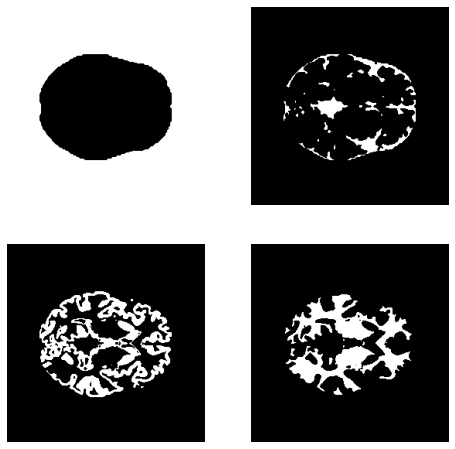

In [53]:
# Check if training data looks all right
_,_,channel= seg_train[60].shape
print("number of channel: ", channel)

fig=plt.figure(figsize=(8, 8))
for i in range(channel):
    s = seg_train[60][:,:,i]
    fig.add_subplot(2, 2, i+1)
    s[s == 1] = 255
    plt.imshow(s)
    plt.gray()
    plt.axis('off')
plt.show()

In [54]:
print("img_train",img_train.shape)
print("img_test",img_test.shape)
print("img_validate",img_validate.shape)
print("seg_train",seg_train.shape)
print("seg_test",seg_test.shape)
print("seg_validate",seg_validate.shape)

img_train (544, 256, 256, 1)
img_test (544, 256, 256, 1)
img_validate (544, 256, 256, 1)
seg_train (544, 256, 256, 4)
seg_test (544, 256, 256, 4)
seg_validate (544, 256, 256, 4)


In [55]:
img_train = np.array(img_train)
seg_train = np.array(seg_train)
img_test = np.array(img_test)
seg_test = np.array(seg_test)

### Build and train our neural network
Next, we build our U-Net model, loosely based on U-Net: Convolutional Networks for Biomedical Image segmentation: https://arxiv.org/pdf/1505.04597.pdf

### U-NET STRUCTURE
The introduced architecture had two main parts that were encoder and decoder. The encoder is all about the covenant layers followed by pooling operation. It is used to extract the factors in the image. The second part decoder uses transposed convolution to permit localization. 

The downsampling path in U-Net consists of 4 blocks with the following layers:

1. 3×3 CONV (ReLU + Batch Normalization and Dropout used)
2. 3×3 CONV (ReLU + Batch Normalization and Dropout used)
3. 2×2 Max Pooling
4. Feature maps double as we go down the blocks, starting at 64, then 128, 256, and 512.

Bottleneck consists of 2 CONV layers with Batch Normalization & Dropout\
The upsampling path consists of 4 blocks with the following layers:
1. Deconvolution layer
2. Concatenation with the feature map from the corresponding contracting path
3. 3×3 CONV (ReLU + Batch Normalization and Dropout used)
4. 3×3 CONV (ReLU + Batch Normalization and Dropout used)

**Transposed convolution** is an upsampling technic that expands the size of images. Basically, it does some padding on the original image followed by a convolution operation.\
After the transposed convolution, the image is upsized from 16x16x256 → 32x32x128, and then, this image is **concatenated with the corresponding image** from the contracting path and together makes an image of size 32x32x256. The reason here is to combine the information from the previous layers in order to get a more precise prediction.

- He initialization works better for layers with ReLu activation.
- It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
- Exponential Linear Unit (or ELU) - test a faster decrease in error rate was reported as well as lower error rates.

In [56]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# imput image tile
inputs = Input((height, width, channels))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# output segmentation map
outputs = Conv2D(4, (1, 1), activation='softmax') (c9)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_20[0][0]                  
_______________________________________________________________________________________

We use some callbacks to save the model while training, lower the learning rate if the validation loss plateaus and perform early stopping.\
The results are both positive and negative. Yes, we do observe in line with the authors that ELU results in faster convergence and hence a speed-up training process, but we also observe that overfitting occurs faster when ConvNets are trained with ELU. Hence, when considering ELU, you may wish to use **EarlyStopping** with ModelCheckpointing in parallel to stop at precisely the correct point.\
Also we use **ReduceLROnPlate** to reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.\
***factor*** by which the learning rate will be reduced. new_lr = lr * factor.\
***lower*** bound on the learning rate.

Note: verbose=1 will show you an animated progress bar like this:
[======================================]

In [57]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1)
]

In [58]:
history = model.fit(img_train, seg_train, batch_size=32, epochs=10, callbacks = callbacks, 
                    shuffle=True, validation_data=(img_validate, seg_validate))

Epoch 1/10
17/17 [==============================] - 188s 11s/step - loss: 0.6514 - accuracy: 0.7925 - val_loss: 0.4698 - val_accuracy: 0.8407
Epoch 2/10
17/17 [==============================] - 189s 11s/step - loss: 0.3390 - accuracy: 0.9019 - val_loss: 0.2289 - val_accuracy: 0.9083
Epoch 3/10
17/17 [==============================] - 189s 11s/step - loss: 0.3476 - accuracy: 0.8920 - val_loss: 0.5613 - val_accuracy: 0.7986
Epoch 4/10
17/17 [==============================] - 187s 11s/step - loss: 0.3977 - accuracy: 0.8866 - val_loss: 0.2393 - val_accuracy: 0.9009
Epoch 5/10
17/17 [==============================] - 189s 11s/step - loss: 0.3866 - accuracy: 0.9031 - val_loss: 0.1579 - val_accuracy: 0.9382
Epoch 6/10
17/17 [==============================] - 194s 11s/step - loss: 0.1868 - accuracy: 0.9505 - val_loss: 0.1443 - val_accuracy: 0.9431
Epoch 7/10
17/17 [==============================] - 194s 11s/step - loss: 0.1841 - accuracy: 0.9483 - val_loss: 0.1377 - val_accuracy: 0.9447
Epoch 

<Figure size 864x432 with 0 Axes>

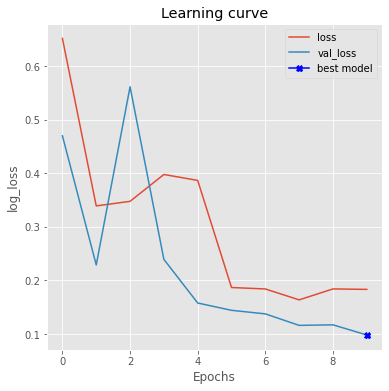

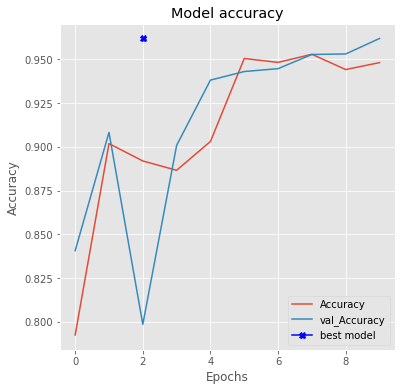

In [59]:
fig=plt.figure(figsize=(12, 6))
plt.figure(figsize=(6, 6))
# fig.add_subplot(6, 6, 1)
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="X", color="b", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(6, 6))
# fig.add_subplot(6, 6, 2)
plt.title('Model accuracy')
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Accuracy")
plt.plot( np.argmin(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="X", color="b", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [60]:
print('\nTesting ------------')
# Evaluate the cifar with the metrics we defined earlier
loss, accuracy = model.evaluate(img_test, seg_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)


Testing ------------
17/17 [==============================] - 30s 2s/step - loss: 0.0983 - accuracy: 0.9620

test loss:  0.09832971543073654

test accuracy:  0.9619580507278442


### Make predictions
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Generates output predictions for the input samples.\
note: Remember to load the best-saved model if you've used early stopping.
***return***: Numpy array(s) of predictions.

In [68]:
# Predict on train, val and test
preds_train = model.predict(img_train, verbose=1)
preds_val = model.predict(img_validate, verbose=1)
preds_test = model.predict(img_test,verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.7).astype(np.float32)
preds_val_t = (preds_val > 0.7).astype(np.float32)
preds_test_t = (preds_test > 0.7).astype(np.float32)

17/17 [==============================] - 29s 2s/step


prediction train result:


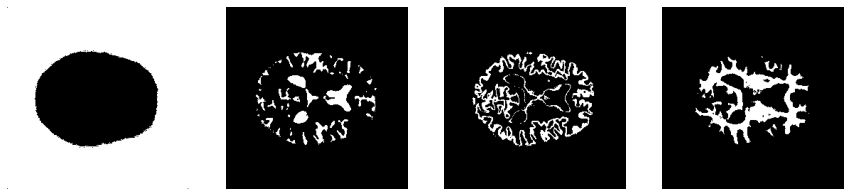

prediction test result:


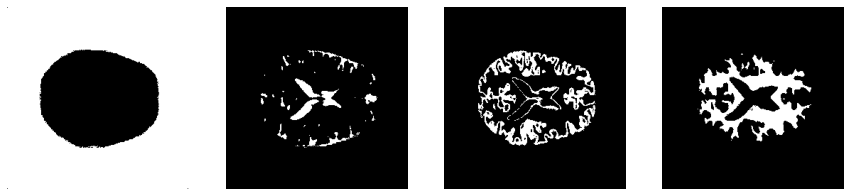

prediction validate result:


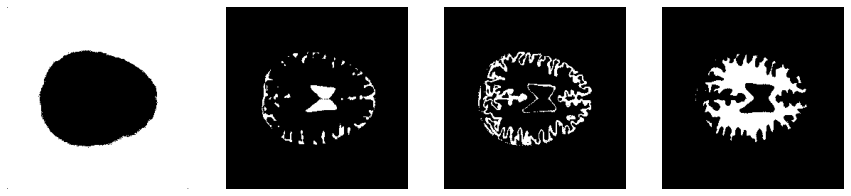

In [69]:
print("prediction train result:")
_,_,channel= preds_train_t[66].shape
fig=plt.figure(figsize=(15, 15))
for i in range(channel):
    s = preds_train_t[66][:,:,i]
    fig.add_subplot(1, 4, i+1)
    s[s == 1] = 255
    plt.imshow(s)
    plt.gray()
    plt.axis('off')
plt.show()

print("prediction test result:")
_,_,channel= preds_test_t[77].shape
fig=plt.figure(figsize=(15, 15))
for i in range(channel):
    s = preds_test_t[77][:,:,i]
    fig.add_subplot(1, 4, i+1)
    s[s == 1] = 255
    plt.imshow(s)
    plt.gray()
    plt.axis('off')
plt.show()

print("prediction validate result:")
_,_,channel= preds_val_t[88].shape
fig=plt.figure(figsize=(15, 15))
for i in range(channel):
    s = preds_val_t[88][:,:,i]
    fig.add_subplot(1, 4, i+1)
    s[s == 1] = 255
    plt.imshow(s)
    plt.gray()
    plt.axis('off')
plt.show()